In [411]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [412]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import warnings
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import KBinsDiscretizer

In [413]:
import time
import psutil
import os
# Hàm để lấy thông tin RAM và disk usage
def get_system_usage():
    # RAM usage
    memory_info = psutil.virtual_memory()
    ram_usage = memory_info.used / (1024 ** 3)  # convert to GB

    # Disk usage
    disk_info = psutil.disk_usage('/')
    disk_usage = disk_info.used / (1024 ** 3)  # convert to GB

    return ram_usage, disk_usage

# Ghi nhận thời gian bắt đầu và thông tin hệ thống
start_time = time.time()
initial_ram_usage, initial_disk_usage = get_system_usage()

# Huấn luyện mô hình dùng API

In [414]:
# Tải tệp CSV
features_train_file_path = '/content/drive/MyDrive/Colab Notebooks/Data_Mining_TH/Đồ Án Cuối Môn_KKDL/Đánh Giá So Sánh/Dataset_CSV_5labels/5lables_features_train.csv'
features_test_file_path = '/content/drive/MyDrive/Colab Notebooks/Data_Mining_TH/Đồ Án Cuối Môn_KKDL/Đánh Giá So Sánh/Dataset_CSV_5labels/5labels_features_test.csv'
features_train_df = pd.read_csv(features_train_file_path)
features_test_df = pd.read_csv(features_test_file_path)

In [415]:
print(features_train_df.columns)
print(features_test_df.columns)

Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_0', 'correlation_45',
       'correlation_90', 'correlation_135', 'label'],
      dtype='object')
Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_

In [416]:

# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings('ignore')

# Đọc dữ liệu
features_df = features_train_df

# Loại bỏ cột 'label' khỏi tập đặc trưng
features = features_df.drop(columns=['label'])

# Chuyển đổi các giá trị đặc trưng thành dạng rời rạc
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discrete_features = discretizer.fit_transform(features)

# Chuyển đổi ngược lại thành DataFrame để dễ xử lý
discrete_features_df = pd.DataFrame(discrete_features, columns=features.columns)

# Tạo danh sách giao dịch có gắn nhãn đặc trưng
transactions_list = [[f'{col}_{int(val)}' for col, val in row.items()] for index, row in discrete_features_df.iterrows()]

# Sử dụng TransactionEncoder để chuyển đổi danh sách giao dịch thành DataFrame nhị phân
te = TransactionEncoder()
binary_features_df = pd.DataFrame(te.fit(transactions_list).transform(transactions_list), columns=te.columns_)

# Sử dụng thuật toán Apriori để tìm các tập hợp thường xuyên
frequent_itemsets = apriori(binary_features_df, min_support=0.6, use_colnames=True)

# Tạo các luật kết hợp từ các tập hợp thường xuyên
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Đánh giá các luật dựa trên các chỉ số
min_support = 0.6
min_confidence = 0.7
min_lift = 1.0
evaluated_rules = rules[(rules['support'] >= min_support) & (rules['confidence'] >= min_confidence) & (rules['lift'] >= min_lift)]

# Xác định các thuộc tính quan trọng từ các luật kết hợp
important_features = pd.Series(evaluated_rules['antecedents'].tolist() + evaluated_rules['consequents'].tolist()).value_counts()
important_features_df = important_features.reset_index()
important_features_df.columns = ['attribute', 'count']

# Chuyển đổi frozenset thành chuỗi và lấy tên các thuộc tính gốc
def extract_feature_names(frozenset_str):
    return [feat.split('_')[0] for feat in frozenset_str.replace('frozenset({', '').replace('})', '').replace("'", "").replace('(', '').replace(')', '').split(', ')]

important_original_features = set()
for item in important_features_df['attribute'].tolist():
    if isinstance(item, str) and 'frozenset' in item:
        item = eval(item)
    if isinstance(item, frozenset):
        for sub_item in item:
            important_original_features.update(extract_feature_names(sub_item))
    else:
        important_original_features.update(extract_feature_names(item))

important_original_features = list(important_original_features)
important_original_features.append('label')

print("Các thuộc tính gốc quan trọng:")
print(important_original_features)



Các thuộc tính gốc quan trọng:
['energy', 'entropy', 'homogeneity', 'correlation', 'contrast', 'label']


In [417]:
# Lấy các giá trị duy nhất trong cột attribute
unique_attributes = important_features_df['attribute'].unique()

# Chuyển đổi frozenset thành danh sách các thuộc tính gốc dễ hiểu
important_features_list = set()
for attr in unique_attributes:
    if isinstance(attr, frozenset):
        important_features_list.update(attr)
    else:
        important_features_list.add(attr)
# Hiển thị danh sách các thuộc tính gốc dễ hiểu
print("Danh sách các thuộc tính gốc dễ hiểu:")
print(important_features_list)

Danh sách các thuộc tính gốc dễ hiểu:
{'energy_intensity_6', 'correlation_90_0', 'energy_45_0', 'contrast_135_0', 'entropy_intensity_3', 'homogeneity_0_0'}


In [449]:
important_features = ['entropy_intensity','energy_intensity', 'variance_intensity','correlation_90', 'contrast_135','homogeneity_0','energy_45','label']

In [450]:
combined_df = pd.concat([features_train_df, features_test_df])
combined_df = combined_df[important_features]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1367 entries, 0 to 133
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   entropy_intensity   1367 non-null   float64
 1   energy_intensity    1367 non-null   float64
 2   variance_intensity  1367 non-null   float64
 3   correlation_90      1367 non-null   float64
 4   contrast_135        1367 non-null   float64
 5   homogeneity_0       1367 non-null   float64
 6   energy_45           1367 non-null   float64
 7   label               1367 non-null   object 
dtypes: float64(7), object(1)
memory usage: 96.1+ KB


In [441]:
X_combined = combined_df.drop('label', axis=1)
y_combined = combined_df['label']
# Split the combined dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined)

In [442]:
# Sử dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [443]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [444]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

In [445]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Khởi tạo mô hình RandomForest
model = RandomForestClassifier(n_estimators=500,
                                max_depth=40,
                                class_weight="balanced")

In [446]:
# Huấn luyện mô hình
model.fit(X_train_scaled, y_train_encoded)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_scaled)

In [447]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Đánh giá mô hình
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.7043795620437956
Classification Report:
                    precision    recall  f1-score   support

Michelia chapensis       0.73      0.79      0.76        70
Osmanthus fragrans       0.65      0.67      0.66        46
          Platanus       0.67      0.61      0.64        57
Sapindus saponaria       0.70      0.66      0.68        59
 Triadica sebifera       0.77      0.79      0.78        42

          accuracy                           0.70       274
         macro avg       0.70      0.70      0.70       274
      weighted avg       0.70      0.70      0.70       274



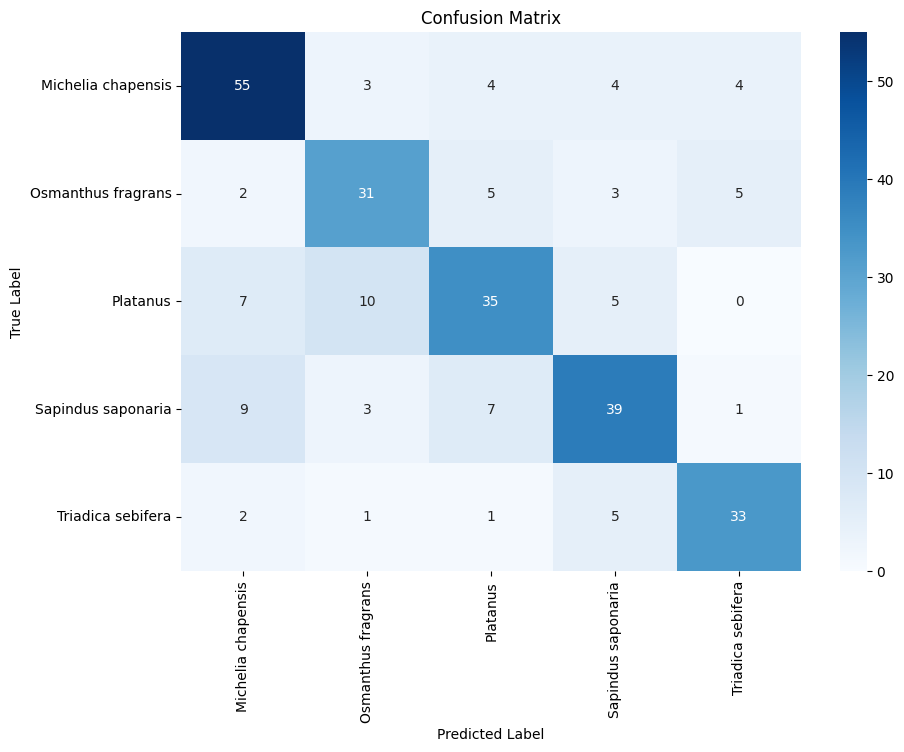

array([[55,  3,  4,  4,  4],
       [ 2, 31,  5,  3,  5],
       [ 7, 10, 35,  5,  0],
       [ 9,  3,  7, 39,  1],
       [ 2,  1,  1,  5, 33]])

In [448]:
# Trực quan hóa ma trận nhầm lẫn
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
cm

In [428]:
# Ghi nhận thời gian kết thúc và thông tin hệ thống
end_time = time.time()
final_ram_usage, final_disk_usage = get_system_usage()

# Tính toán thời gian chạy, RAM và disk usage
execution_time = end_time - start_time
ram_usage_diff = final_ram_usage - initial_ram_usage
disk_usage_diff = final_disk_usage - initial_disk_usage

print(f'Execution Time: {execution_time} seconds')
print(f'RAM Usage Increase: {ram_usage_diff} GB')
print(f'Disk Usage Increase: {disk_usage_diff} GB')

Execution Time: 8.104125261306763 seconds
RAM Usage Increase: 0.008129119873046875 GB
Disk Usage Increase: 0.0 GB
